Kiet Nguyen

ID: 001601720

Email: kngu179@wgu.edu

### A. Purpose of Analysis

#### A1. Research Question

Can we predict whether a customer like or dislike a product on Amazon using reviews by other customers?

#### A2. Analysis Goal

The goal of this analysis is to analyze and predict how a customer feel toward a product based on the words in the review.

#### A3. Type of Neural Network

The type of neural network we will be using is Recurrent Neural Network (RNN). RNN is designed to handle sequential data such as texts. It performs the same computations for every element in the sequence and the output depends on whatever elements came before. At each time step, a recurrent neuron produces an output along with a hidden state. These states can be thought of as the memory of the network. This memory allows RNN to consolidate history information and generate accurate predictions (Halder, 2022).

### B. Data Cleaning

##### Import Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

from tensorflow import keras
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, GlobalAveragePooling1D

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Import Datasets

In [2]:
# Load txt files to dataframes
df = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None)

# Assign column names
col_names = ['Review', 'Sentiment']
df.columns = col_names

#### B1. Exploratory Data Analysis

##### Check imported dataset

In [3]:
df

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


##### Countplot of sentiment categories

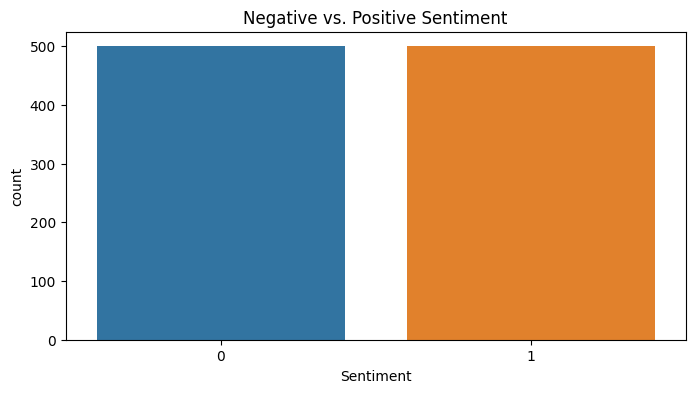

In [4]:
fig = plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Sentiment')
plt.title('Negative vs. Positive Sentiment')
plt.show()

##### Check for Unusual Characters

Many reviews contained special symbols, non-English characters, and emojis. We can detect them by printing out a list of unique characters from all reviews.

In [5]:
# Add unique characters to list
chars = []
for word in df['Review']:
    for char in word:
        if char not in chars:
            chars.append(char)
            
print(chars)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']']


##### Find Vocabulary Size

Vocabulary size is the number of unique words in all of the reviews. We will use the `Tokenizer` method from `keras` to vectorize the text. Then we will fit the tokenizer object on the reviews to break them down into a vocabulary dictionary. This will allow us to determine the vocabulary size. 

In [6]:
# Create tokenizer object with filters
tokenizer = Tokenizer()

# Fit on reviews
tokenizer.fit_on_texts(df['Review'])

# Print vocabulary size
vocab_dict = tokenizer.word_index
vocab_size = len(vocab_dict) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 1879


##### Find Word Embedding Length

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. Individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network (Brownlee, 2019). Embedding length is the fourth root of the vocabulary size, which can then be rounded up to the nearest integer.

In [7]:
# Calculate embedding length of vocab size
embed_len = int(round(np.sqrt(np.sqrt(len(vocab_dict))), 0))

print(f'Word embedding length: {embed_len}')

Word embedding length: 7


##### Sequence Length Justification

We need to choose a maximum sequence length due to the way that RNN algorithm accepts input. RNN takes in batches of sequences at once but the sequence length of each batch has to be equal. That means that if a sequence in a batch is too long, it will get truncated. But if a sequence is short, we can simply use padding. By using a maximum sequence length, we can preserve all of the available input (Halder, 2022).

We will find this length in section B5 during data preparation. This is because the maximum sequence length might be different after the data is cleaned.

#### B2. Goal of Tokenization

Tokenization is the process of splitting text into separate words or characters, using a delimiter such as the space character. This preprocessing is necessary because RNN cannot work with unstructured text data. The algorithm needs the data to be broken down into discrete tokens before analysis can be conducted (Menzli, 2022). The method `Tokenizer()` from `tensorflow.keras` package was used to tokenize and normalize the text. Below are ten examples from the word index of the tokenized vocabulary in section B1. 

In [8]:
# Display 10 tokens from word index
list(vocab_dict.items())[40:50]

[('would', 41),
 ('work', 42),
 ('from', 43),
 ('your', 44),
 ('like', 45),
 ('be', 46),
 ('me', 47),
 ('case', 48),
 ('if', 49),
 ('than', 50)]

#### B3. Padding Process

The RNN algorithm requires the input sequences to be of the same shape and size. We need to add padding with shorter sequences to adhere to this specification. This ensures that when a batch of sequences is passed into RNN, each individual sequence will be of the same length. We used pre-padding for this process since post-padding performed worse on LSTMs, a type of RNN that we use for text generation, compared to pre-padding (Reddy & Reddy, 2019).

An example of a padded sequence can be found in section B5 during data preparation. 

#### B4. Sentiment Categories

We can use the labels of 0 and 1 for the sentiment, with 0 being negative and 1 being positive. These two categories will be used for the sentiment analysis output. In the final dense layer of RNN, we will calculate the sentiment output using the `softmax` activation function. This function is used to normalize the outputs and convert them into probabilities of membership in each category (Brownlee, 2020b).

#### B5. Preparation Steps

To prepare the data for analysis, we need to perform the following steps:

1. Remove unusual characters with regular expression.
2. Breaking reviews down with tokenization.
3. Remove stop words from data.
4. Reduce words to their base forms using lemmatization.
5. Find maximum sequence length.
6. Divide data into training/testing sets with 80/20 split.
7. Pre-pad sequences to maximum sequence length.

We will do step 1 through 4 using one loop below for efficiency.

##### Step 1 through 4

In [9]:
reviews_list = []
stop_words = stopwords.words('english')
for review in df['Review']:
    # 1. Remove special characters with regex
    review = re.sub('[^a-zA-Z ]', '', review)
    
    # 2. Tokenize review
    review = review.lower()
    review = word_tokenize(review)  # Tokenize review
    
    # 3. Remove stopwords
    review = [word for word in review if word not in stop_words]
    
    # 4. Lemmatize words in each review
    lem = WordNetLemmatizer()       
    review = [lem.lemmatize(word) for word in review]
    
    # Join back the string and append to list
    review = ' '.join(review)
    reviews_list.append(review)

In [10]:
# Assign cleaned reviews to dataframe
df['Clean Review'] = reviews_list

# Rearrange order of columns
df = df[['Review', 'Clean Review', 'Sentiment']]

# Check cleaned data
df.head()

,Review,Clean Review,Sentiment
0,So there is no way for me to plug it in here i...,way plug u unless go converter,0
1,"Good case, Excellent value.",good case excellent value,1
2,Great for the jawbone.,great jawbone,1
3,Tied to charger for conversations lasting more...,tied charger conversation lasting minutesmajor...,0
4,The mic is great.,mic great,1


##### 5. Find maximum sequence length

In [11]:
# Find longest input from reviews
max_seq = 0
for review in df['Clean Review']:
    review_len = len(review.split(' '))
    if review_len > max_seq:
        max_seq = review_len

print(f'Maximum sequence length: {max_seq}')

Maximum sequence length: 16


##### 7. Split into training/testing sets

In [12]:
# Do 80/20 split
X = df['Clean Review']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

##### 6. Pre-pad sequences

In [13]:
# Pad training
train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(train_sequences, maxlen=max_seq, padding='pre')

# Pad testing set
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(test_sequences, maxlen=max_seq, padding='pre')

# Print a padded training sample
padded_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 150, 163,
       193, 737,  25])

#### B6. Copy of Prepared Dataset

In [14]:
# Export files to CSV
df.to_csv('clean_data.csv', index=False)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

### C. Network Description

##### Create RNN with 6 Layers

In [15]:
# Adapted from Natural Language Generation in Python (Halder, 2022)
# https://app.datacamp.com/learn/courses/natural-language-generation-in-python

# Create RNN
model = Sequential([
    Embedding(vocab_size, embed_len, input_length=max_seq),
    GlobalAveragePooling1D(),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### C1. Model Summary

In [16]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 7)             13153     
                                                                 
 global_average_pooling1d (G  (None, 7)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 20)                160       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 13,545
Trainable params: 13,545
Non-trainable params: 0
____________________________________________________

#### C2. Network Description

There are five layers in our network. They are detailed in the table below.

| Layer | Layer Type | Core Type | Parameters |
|:-----:|:----------:|:---------:|:----------:|
|  1st  |    Input   | Embedding |    13153   |
|  2nd  |   Flatten  |  Flatten  |      0     |
|  3rd  |   Hidden   |   Dense   |     160    |
|  4th  |   Hidden   |   Dense   |     210    |
|  5th  |   Output   |   Dense   |     22     |

#### C3. Choice of Hyperparameters

##### 1. Activation Functions

We used two activation functions in the model, ReLu and Softmax. ReLu is frequently used for hidden layers due to its simple computation and good performance. It also does not suffer from vanishing gradient problem. Softmax produces a probability distribution between 0 and 1, which makes it ideal for classification problems such as sentiment analysis (Sharma, 2020).

##### 2. Number of Nodes

We chose the initial number of nodes as an experiment. Since we do not have the data on the optimal number, we selected 20 and 10 nodes for the first and second hidden layers, respectively. These numbers gave us a good starting point. We can increase the network capacity by adding more nodes to each layer later if we want to improve the accuracy.

##### 3. Loss Function

Categorical crossentropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. We selected sparse categorical crossentropy because this function performs the same calculation as categorical crossentropy and it also one hot encodes the data for us (Brownlee, 2020a). This loss function is designed to quantify the difference between two probability distributions.

##### 4. Optimizer

The `adam` optimizer is the most versatile algorithm for most problems. It automatically adjusts the learning rate as it performs gradient descent. This ensures the values remain reasonable throughout the weight optimization process (Halder, 2022). It is efficient on both computation and memory usage. It can also handle random noise in the model, leading to less overfitting.

##### 5. Stopping Criteria

We will use a stopping criteria of two epochs. This means the model will stop training when the accuracy score stops improving after two epochs. This will prevent the model from overfitting on the training data. Having a stopping criteria will also help with improving generalization on the testing set.

##### 6. Evaluation Metric

##### Fit the Model

In [17]:
# Define early stopping 
early_stop = EarlyStopping(patience=2)

rnn = model.fit(padded_train, y_train, epochs=20, validation_split=0.2, callbacks=early_stop, verbose=True)

Epoch 1/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.4563
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5094 - val_loss: 0.6926 - val_accuracy: 0.4563
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5969 - val_loss: 0.6881 - val_accuracy: 0.6938
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.7219 - val_loss: 0.6841 - val_accuracy: 0.5375
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.7969 - val_loss: 0.6702 - val_accuracy: 0.7250
Epoch 6/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.8938 - val_loss: 0.6603 - val_accuracy: 0.5813
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.8766 - val_loss: 0.6286 - val_accuracy: 0.7125
Epoch 8/20
20/20 [==

In [18]:
# Evaluate model on test data
score = model.evaluate(padded_test, y_test, verbose=False)
print(f'Test Loss: {score[0]}')
print(f'Test Accuracy: {score[1]}')

Test Loss: 0.4194900095462799
Test Accuracy: 0.8050000071525574


##### Evaluation

The accuracy metrics were:

- Training: 97.34%
- Validation: 78.75%
- Test: 80.5%

We used accuracy as the evaluation metric. A high score means that the model could classify the right sentiment to the review. It will also serve as a gauge of whether our model overfit. An overfit model will have a very high score on training set but mediocre score on the test set. Our model performed well on the training data but it did not achieved the same results with the validation and test set. But because we used early stopping criteria, the model stopped training at epoch 15 when the validation accuracy did not improve further.

### D. Model Evaluation

#### D1. Impact of Stopping Criteria

When training the model above, the stopping criteria prevented the model from overfitting. It stopped the model from training at epoch 15 when it could not improve the validation score further. Without a stopping criteria, the model would continue training for all 20 epochs even if the validation score stops improving. Since we do not know the optimal number of epochs before training, stopping criteria is a simple way to prevent the model from overfitting (Halder, 2022).

#### D2. Training Visualizations

##### Accuracy Plot

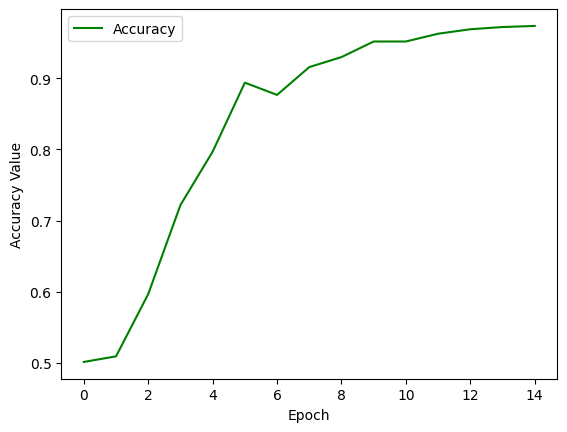

In [19]:
accuracies = rnn.history['accuracy']
sns.lineplot(data=accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

##### Loss Plot

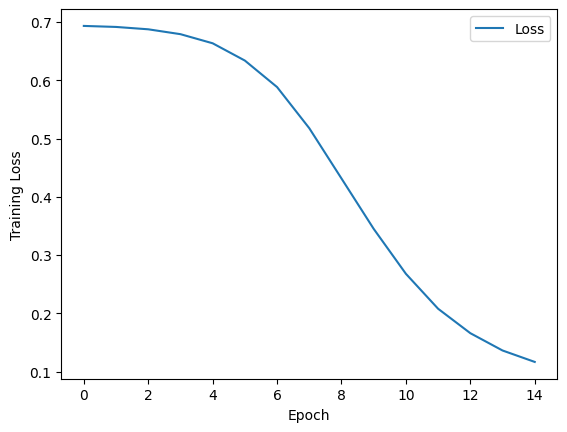

In [20]:
losses = rnn.history['loss']
sns.lineplot(data=losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

#### D3. Model Fitness

Our model did not overfit to the training data. It stopped at epoch 15 when it could not improve the accuracy anymore. To achieve a good model fit, we used the following methods:

- Starting with a small network with just 5 layers, with 20 nodes and 10 nodes in the hidden layers. This gives us a lot of room to add more nodes and layers to increase network capacity later.
- We divided the training set into 80/20 split with the other 20% reserved for the validation set.
- Create an early stopping criteria to stop the model when it stops improving after two epochs.

To improve the model further, we can increase the input data. This would provide the model with even more samples to train on, which can lead to better performance.

#### D4. Predictive Accuracy

The accuracy metrics were:

- Training: 97.34%
- Validation: 78.75%
- Test: 80.5%

While our model accuracy is 97%, we cannot claim that it can perform that well on unseen data. The metric we should evaluate this model on are the validation and test accuracy. Both of those scores are around 80%. While those seems like good scores, a data size of 1000 samples is quite small training a neural network. This model can be more reliable once it has more data input.

### E. Save the Network

In [21]:
model.save('sentiment_model.h5')

### F. Network Functionality

The model can be used to perform sentiment analysis on customer reviews. This primary functionality can help us predict whether a customer liked a product or not. For the network architecture, we used five layers. However, since one layer is used to flatten the data, only four layers were involved in the training. For the two hidden layers, we only used 20 nodes and 10 nodes. This is appropriate since our dataset is quite small. Having too many nodes will overfit the data and uses up more resources. One thing we can add to this architecture is a dropout layer to increase the robustness of the network.

### G. Recommendation

In theory, our model can predict customer sentiment correct 80% of the time. However, we would advise not to use our model on real customer data yet. We trained the model on a very small sample of customers so it may not deliver the same result in the real setting. We recommend the company train this model on significantly more samples and increase the complexity of the neural network. This will ensure the model becomes accurate enough for real world use.

### H. Notebook Presentation

The Jupyter Notebook for this analysis will be exported as a PDF document.

### I. Third-Party Code

Halder, B. (2022). Natural Language Generation in Python. DataCamp. Retrieved August 18, 2022, from https://app.datacamp.com/learn/courses/natural-language-generation-in-python

### J. References

Brownlee, J. (2019, August 7). What Are Word Embeddings for Text? Machine Learning Mastery. Retrieved August 18, 2022, from https://machinelearningmastery.com/what-are-word-embeddings/

Brownlee, J. (2020a, August 25). How to Choose Loss Functions When Training Deep Learning Neural Networks. Machine Learning Mastery. Retrieved August 21, 2022, from https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

Brownlee, J. (2020b, October 19). Softmax Activation Function with Python. Machine Learning Mastery. Retrieved August 20, 2022, from https://machinelearningmastery.com/softmax-activation-function-with-python/

Halder, B. (2022). Natural Language Generation in Python. DataCamp. Retrieved August 18, 2022, from https://app.datacamp.com/learn/courses/natural-language-generation-in-python

Menzli, A. (2022, July 21). Tokenization in NLP: Types, Challenges, Examples, Tools. Neptune.Ai. Retrieved August 19, 2022, from https://neptune.ai/blog/tokenization-in-nlp

Reddy, D. M., & Reddy, N. V. S. (2019, March 18). Effects of Padding on LSTMs and CNNs. arXiv. Retrieved August 19, 2022, from https://arxiv.org/pdf/1903.07288.pdf

Sharma, P. (2021, March 9). Keras Activation Layers - Ultimate Guide for Beginners. MLK - Machine Learning Knowledge. Retrieved August 21, 2022, from https://machinelearningknowledge.ai/keras-activation-layers-ultimate-guide-for-beginners/